# Data Mining Project

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from random import sample
import random
from tensorflow import keras 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN, SimpleRNN
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation
from keras.callbacks import LambdaCallback
from sklearn.preprocessing import MinMaxScaler



In [2]:
# Load dataset
bike = pd.read_csv("https://raw.githubusercontent.com/vedantw29/Data-Mining-Project/main/Bike-sharing-day.csv")

In [3]:
# Keep relevant columns
bike = bike.drop(columns=['atemp', 'casual', 'registered'])

In [4]:
test = []
for i in range(len(bike['dteday'])) :
    test.append(datetime.strptime(bike['dteday'][i], '%Y-%m-%d'))

In [5]:
# Convert to categorical variables
bike['season'] = bike['season'].astype('category',copy=False)
bike['holiday'] = bike['holiday'].astype('category',copy=False)
bike['weekday'] = bike['weekday'].astype('category',copy=False)
bike['workingday'] = bike['workingday'].astype('category',copy=False)
bike['weathersit'] = bike['weathersit'].astype('category',copy=False)
bike['yr'] = bike['yr'].astype('category',copy=False)
bike['mnth'] = bike['mnth'].astype('category',copy=False)

In [6]:
# Top few observations
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,1600


In [7]:
# Summary statistics
bike.describe()

,instant,temp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,0.495385,0.627894,0.190486,4504.348837
std,211.165812,0.183051,0.142429,0.077498,1937.211452
min,1.000000,0.059130,0.000000,0.022392,22.000000
25%,183.500000,0.337083,0.520000,0.134950,3152.000000
50%,366.000000,0.498333,0.626667,0.180975,4548.000000
75%,548.500000,0.655417,0.730209,0.233214,5956.000000
max,731.000000,0.861667,0.972500,0.507463,8714.000000


In [8]:
bike[['yr','mnth','season','holiday','weekday','workingday','weathersit']].describe()

,yr,mnth,season,holiday,weekday,workingday,weathersit
count,731,731,731,731,731,731,731
unique,2,12,4,2,7,2,3
top,1,1,3,0,0,1,1
freq,366,62,188,710,105,500,463


In [9]:
col = bike.columns
col = col.tolist()
indices = [9,10,11,12]
col = [col[index] for index in indices]

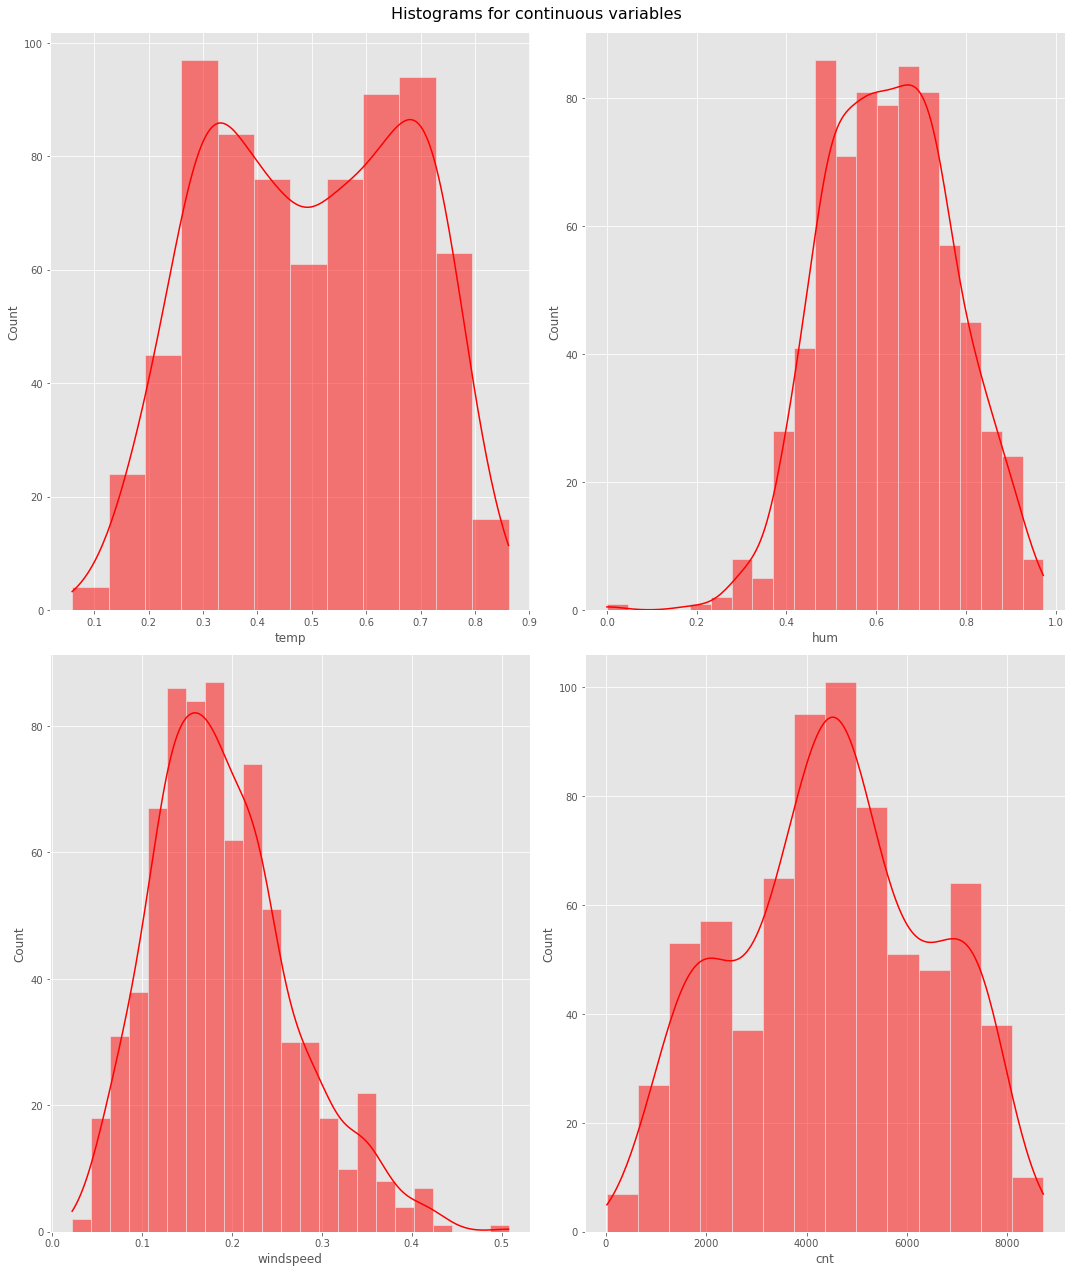

In [10]:
# Density plot and histogram
plt.style.use('ggplot')
fig, axes = plt.subplots(2,2,figsize=(15,18))
for i in col:
    index = col.index(i)
    x = int(index/2)
    y = index%2
    sns.histplot(ax = axes[x,y],x=bike[i],color='red',kde = True)
    axes[x,y].set_xlabel(i)
    plt.suptitle('Histograms for continuous variables', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.96)
plt.show()

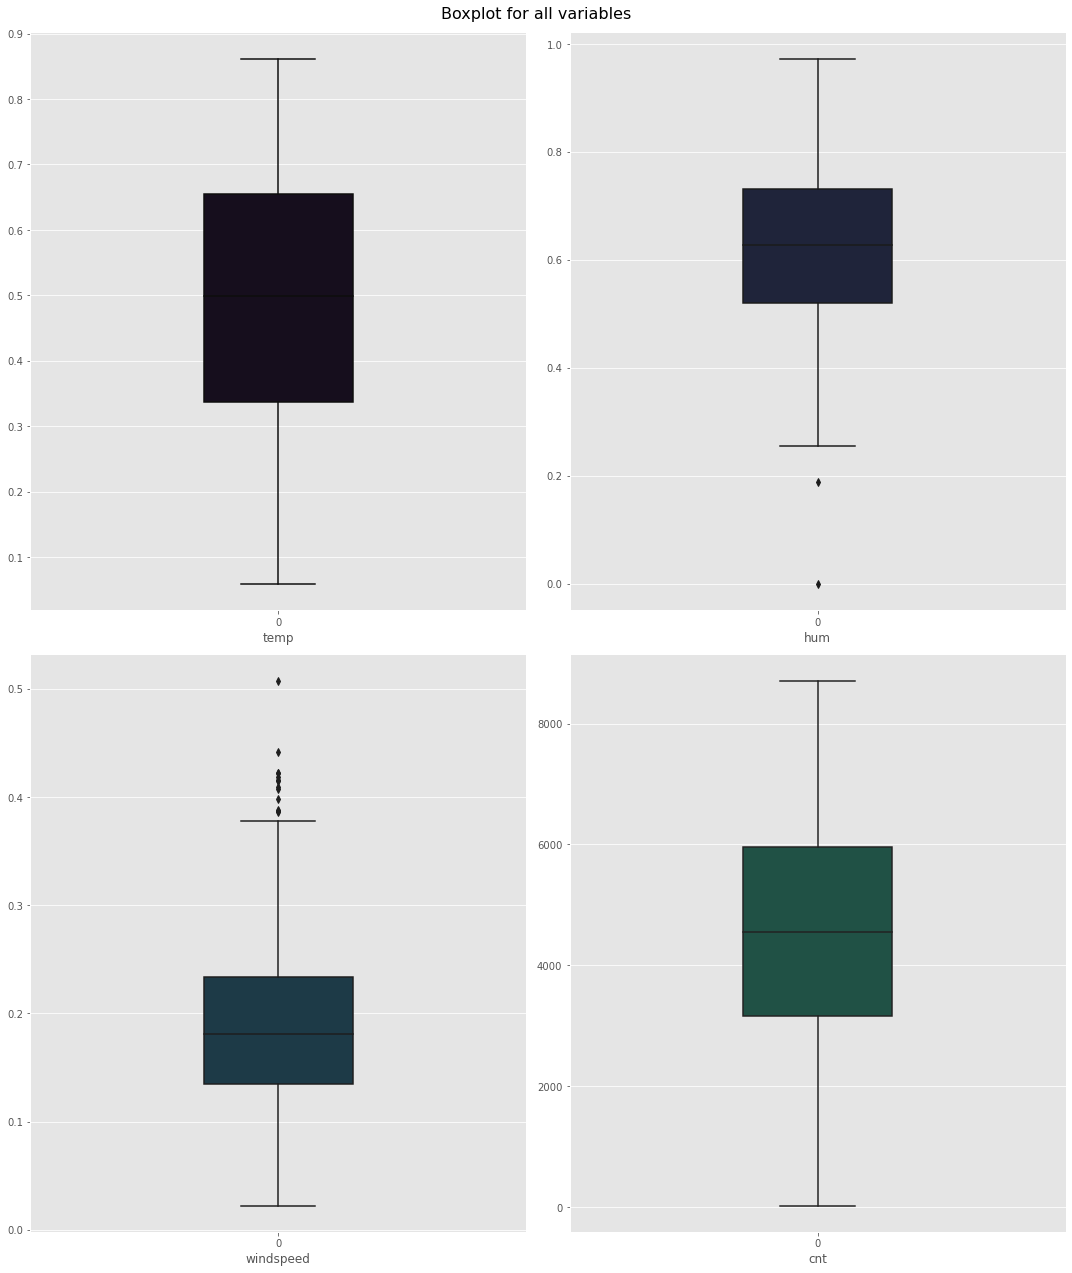

In [11]:
# Boxplots
plt.style.use('ggplot')
fig, axes = plt.subplots(2,2,figsize=(15,18))

p=sns.color_palette("cubehelix", 14)
for i in col:
    index = col.index(i)
    x = int(index/2)
    y = index%2
    sns.boxplot(ax = axes[x,y],data=bike[i],width=0.3,color=p[index])
    axes[x,y].set_xlabel(i)
    plt.suptitle('Boxplot for all variables', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.96)
plt.savefig('boxplots.jpg')

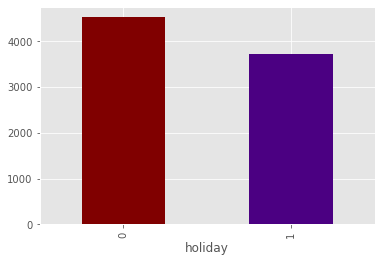

In [12]:
# Bar chart - holiday vs cnt
bike_season = bike.groupby("holiday")["cnt"].mean()
bike_season.plot.bar(color=['maroon', 'indigo'])
plt.show()

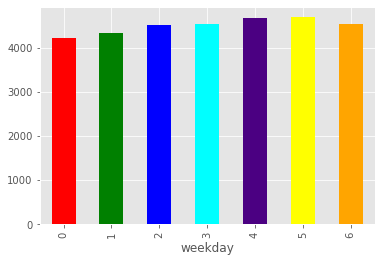

In [13]:
# Bar chart - weekday vs cnt
bike_season = bike.groupby("weekday")["cnt"].mean()
bike_season.plot.bar(color=['red', 'green', 'blue', 'cyan', 'indigo', 'yellow', 'orange'])
plt.show()

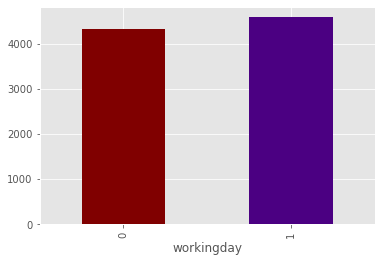

In [14]:
# Bar chart - workingday vs cnt
bike_season = bike.groupby("workingday")["cnt"].mean()
bike_season.plot.bar(color=['maroon', 'indigo'])
plt.show()

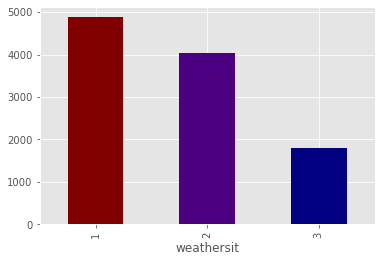

In [15]:
# Bar chart - weathersit vs cnt
bike_season = bike.groupby("weathersit")["cnt"].mean()
bike_season.plot.bar(color=['maroon', 'indigo', 'navy'])
plt.show()

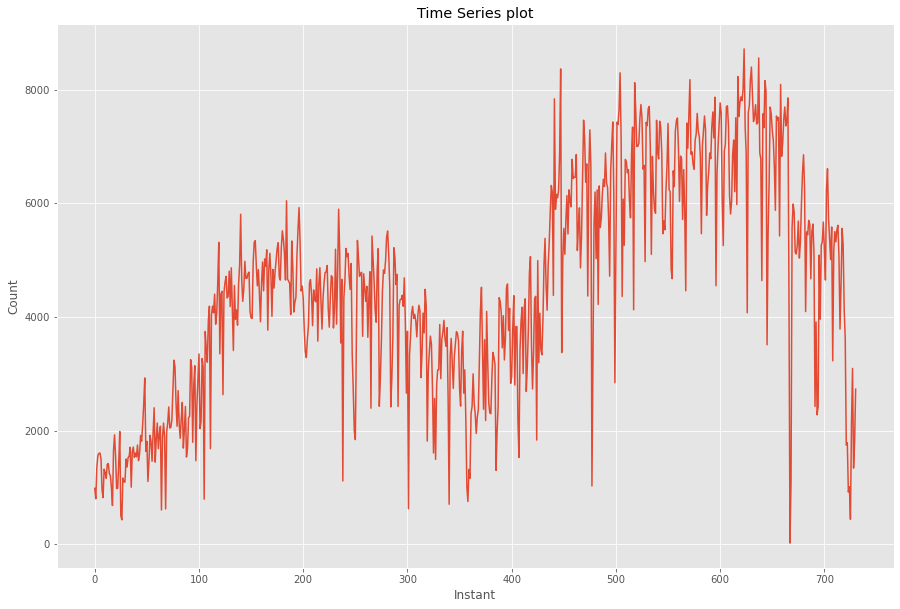

In [16]:
# Time series plot
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
plt.title('Time Series plot')
plt.xlabel('Instant')
plt.ylabel('Count')
f = bike['cnt'].plot()
plt.show()

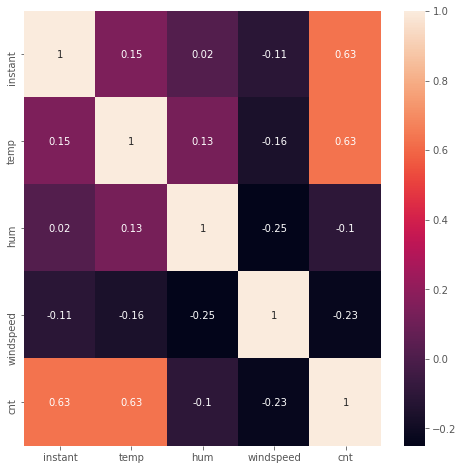

In [17]:
# Correlation matrix - continuous variables
plt.figure(figsize = (8,8))
correlation_matrix = bike.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

In [18]:
# Split data into train and test
from sklearn.model_selection import train_test_split
import random
random.seed(100)

# For statmodels smf function (explained in Model Building section)
num = list(range(len(bike)))
ran = sample(num, int(len(num)*0.7))
rem = [i for i in num if i not in ran] 

bike_train = bike.iloc[ran, :]
bike_test = bike.iloc[rem, :]

# For sklearn LinearRegression function 

X_train = bike_train.iloc[:,:-1]
X_train = X_train.drop(columns=['dteday'])
y_train = bike_train.iloc[:,-1:]

X_test = bike_test.iloc[:,:-1]
X_test = X_test.drop(columns=['dteday'])
y_test = bike_test.iloc[:,-1:]

# Create one-hot encoding
X_train_d = pd.get_dummies(X_train)
X_test_d = pd.get_dummies(X_test)
y_train_d = pd.get_dummies(y_train)
y_test_d = pd.get_dummies(y_test)

In [19]:
# Linear Regression model building
import statsmodels.formula.api as smf
import statsmodels.api as sm

model_l = smf.ols(formula='cnt ~ yr + mnth + instant + season + holiday + weekday + workingday + weathersit + temp + hum + windspeed', data = bike_train).fit()
model_l.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     94.00
Date:                Sat, 07 Aug 2021   Prob (F-statistic):          1.31e-175
Time:                        01:17:07   Log-Likelihood:                -4114.7
No. Observations:                 511   AIC:                             8287.
Df Residuals:                     482   BIC:                             8410.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1680.2719    285.107      5.893      0.000    1120.066    2240.478
yr[T.1]          5146.5513   1450.304      3.549      0.000    2296.852    7996.251
mnth[T.2]         449.5447    210.486      2.136      0.033      35.962     863.127
mnth[T.3]        1056.5999    322.397      3.277      0.001     423.122    1690.078
mnth[T.4]        1422.2659    463.030      3.072      0.002     512.460    2332.072
mnth[T.5]        1930.2542    574.055      3.362      0.001     802.295    3058.214
mnth[T.6]        1830.7950    684.508      2.675      0.008     485.807    3175.783
mnth[T.7]        1879.3613    805.640      2.333      0.020     296.360    3462.363
mnth[T.8]        2495.1228    911.477      2.737      0.006     704.163    4286.082
mnth[T.9]        3237.4467   1002.238      3.230      0.001    1268.152    5206.742
mnth[T.10]       3131.3822   1122.964      2.788      0.006     924.873    5337.892
mnth[T.11]       2702.7316   1235.602      2.187      0.029     274.900    5130.563
mnth[T.12]       2934.9504   1345.885      2.181      0.030     290.424    5579.477
season[T.2]       797.6485    216.879      3.678      0.000     371.503    1223.794
season[T.3]       672.9092    255.155      2.637      0.009     171.555    1174.263
season[T.4]      1407.9020    220.675      6.380      0.000     974.297    1841.507
holiday[T.1]     -183.0060    201.895     -0.906      0.365    -579.710     213.698
weekday[T.1]     -136.2629     86.884     -1.568      0.117    -306.981      34.455
weekday[T.2]        8.6272     96.698      0.089      0.929    -181.375     198.629
weekday[T.3]       57.0697     95.756      0.596      0.551    -131.081     245.220
weekday[T.4]       92.2103     96.555      0.955      0.340     -97.511     281.931
weekday[T.5]      128.1622     94.187      1.361      0.174     -56.906     313.230
weekday[T.6]      335.0622    129.763      2.582      0.010      80.092     590.032
workingday[T.1]   332.8126     83.483      3.987      0.000     168.776     496.849
weathersit[T.2]  -506.1311     95.123     -5.321      0.000    -693.038    -319.225
weathersit[T.3] -1975.9529    250.828     -7.878      0.000   -2468.805   -1483.101
instant            -8.5581      3.957     -2.163      0.031     -16.332      -0.784
temp             4379.0528    497.572      8.801      0.000    3401.375    5356.731
hum             -1419.2015    343.783     -4.128      0.000   -2094.699    -743.704
windspeed       -3208.4567    487.833     -6.577      0.000   -4166.998   -2249.915
==============================================================================
Omnibus:                       98.918   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.249
Skew:                          -0.947   Prob(JB):                     9.28

In [20]:
# Prediction and MSE
pred = model_l.predict(bike_train)

error = bike_train['cnt'] - pred 
RMSE = np.sqrt((error*error).mean())
RMSE

759.9637735329193

In [21]:
# MSPE
pred = model_l.predict(bike_test)

error = bike_test['cnt'] - pred 
RMSE = np.sqrt((error*error).mean())
RMSE

752.5891028995707

In [22]:
model_l.rsquared_adj

0.8362180908740675

In [23]:
# Subset selection

def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y, model_k.predict(X))*len(Y)
    #R_squared = model_k.score(X,Y)
    R_squared = 1 - (1-model_k.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
    return RSS, R_squared

#Implementing Best subset selection (using itertools.combinations)¶
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook
import itertools 

#Initialization variables
Y = y_train['cnt']
X = X_train
k = len(y_train.columns) + 1
RSS_list, R_squared_list, feature_list = [],[],[]
numb_features = []

#Looping over k features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df_f = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 
                   'Adj_R_squared':R_squared_list,'features':feature_list})   

#Finding the best subsets for each number of features
#Using the smallest RSS value, or the largest R_squared value

df_min = df_f[df_f.groupby('numb_features')['RSS'].transform(min) == df_f['RSS']]
df_max = df_f[df_f.groupby('numb_features')['Adj_R_squared'].transform(max) == df_f['Adj_R_squared']]

<ipython-input-23-ac67e1ebde04>:25: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\Sameer\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Sameer\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Sameer\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explici

In [24]:
display(df_max)

,numb_features,RSS,Adj_R_squared,features
8,1,1.153892e+09,0.393608,"(temp,)"
18,2,6.044742e+08,0.681712,"(instant, temp)"
105,3,5.180639e+08,0.726674,"(instant, weathersit, temp)"
373,4,4.361145e+08,0.769455,"(season, yr, weathersit, temp)"
824,5,4.129912e+08,0.781246,"(season, yr, weathersit, temp, windspeed)"
1344,6,4.045329e+08,0.785301,"(season, yr, weathersit, temp, hum, windspeed)"
1749,7,3.984122e+08,0.788129,"(season, yr, weekday, weathersit, temp, hum, w..."
1962,8,3.929248e+08,0.790631,"(season, yr, weekday, workingday, weathersit, ..."
2007,9,3.898543e+08,0.791853,"(instant, season, yr, weekday, workingday, wea..."
2041,10,3.852580e+08,0.793895,"(instant, season, yr, mnth, weekday, workingda..."


In [25]:
#Alternate Function using the AIC values
def stepwise_selection(data, target):
    
    initial_features = data.columns.tolist()
    best_features = []
    
    aic = sm.OLS(target, sm.add_constant(data[best_features])).fit().aic
    
    while (len(initial_features) > 0):
        remaining_features = list(set(initial_features) - set(best_features))
        forw_aic = pd.Series(index = remaining_features)
        
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            forw_aic[new_column] = model.aic
        min_aic = forw_aic.min()
        
        if(min_aic < aic):
            aic = min_aic
            best_features.append(forw_aic.idxmin())

            while (True):
                
                aic = sm.OLS(target, sm.add_constant(data[best_features])).fit().aic
                
                back_aic = pd.Series(index = best_features)
                aic_diff = pd.Series(index = best_features)

                for new_column in best_features:
                    model = sm.OLS(target, sm.add_constant(data[list(set(best_features) - set([new_column]))])).fit()
                    back_aic[new_column] = model.aic
                    aic_diff[new_column] = aic - model.aic

                max_aic = aic_diff.max()

                if(max_aic > 0):
                    best_features.remove(aic_diff.idxmax())
                    aic = back_aic[aic_diff.idxmax()]
                else:
                    break
                
        else:
            break
    
    final_AIC = sm.OLS(target, sm.add_constant(data[list(best_features)])).fit().aic
           
    return best_features, final_AIC

print('The variable coefficients provided by the model are:')
print(stepwise_selection(X_train, y_train)[0])
print('\nFinal AIC value for the model is:')
print(stepwise_selection(X_train, y_train)[1])

The variable coefficients provided by the model are:


<ipython-input-25-4c145aade66b>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forw_aic = pd.Series(index = remaining_features)
<ipython-input-25-4c145aade66b>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_aic = pd.Series(index = best_features)
<ipython-input-25-4c145aade66b>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  aic_diff = pd.Series(index = best_features)


['temp', 'instant', 'weathersit', 'yr', 'season', 'windspeed', 'weekday', 'hum', 'workingday', 'mnth', 'holiday']

Final AIC value for the model is:
8386.498943152177


In [26]:
#Alternate Function using the BIC values
def stepwise_selection(data, target):
    
    initial_features = data.columns.tolist()
    best_features = []
    
    bic = sm.OLS(target, sm.add_constant(data[best_features])).fit().bic
    
    while (len(initial_features) > 0):
        remaining_features = list(set(initial_features) - set(best_features))
        forw_bic = pd.Series(index = remaining_features)
        
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            forw_bic[new_column] = model.bic
        min_bic = forw_bic.min()
        
        if(min_bic < bic):
            bic = min_bic
            best_features.append(forw_bic.idxmin())

            while (True):
                
                bic = sm.OLS(target, sm.add_constant(data[best_features])).fit().bic
                
                back_bic = pd.Series(index = best_features)
                bic_diff = pd.Series(index = best_features)

                for new_column in best_features:
                    model = sm.OLS(target, sm.add_constant(data[list(set(best_features) - set([new_column]))])).fit()
                    back_bic[new_column] = model.bic
                    bic_diff[new_column] = bic - model.bic

                max_bic = bic_diff.max()

                if(max_bic > 0):
                    best_features.remove(bic_diff.idxmax())
                    bic = back_bic[bic_diff.idxmax()]
                else:
                    break
                
        else:
            break
    
    final_BIC = sm.OLS(target, sm.add_constant(data[list(best_features)])).fit().bic
           
    return best_features, final_BIC

print('The variable coefficients provided by the model are:')
print(stepwise_selection(X_train, y_train)[0])
print('\nFinal BIC value for the model is:')
print(stepwise_selection(X_train, y_train)[1])

The variable coefficients provided by the model are:


<ipython-input-26-115f825224e0>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forw_bic = pd.Series(index = remaining_features)
<ipython-input-26-115f825224e0>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_bic = pd.Series(index = best_features)
<ipython-input-26-115f825224e0>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  bic_diff = pd.Series(index = best_features)


['temp', 'weathersit', 'yr', 'season', 'windspeed', 'hum', 'weekday', 'workingday']

Final BIC value for the model is:
8431.7425296577


In [27]:
# Fit model using above variables
model_b = smf.ols(formula='cnt ~ instant + workingday + weathersit + temp + hum + windspeed', data = bike_train).fit()
model_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     226.8
Date:                Sat, 07 Aug 2021   Prob (F-statistic):          3.78e-151
Time:                        01:17:28   Log-Likelihood:                -4227.4
No. Observations:                 511   AIC:                             8471.
Df Residuals:                     503   BIC:                             8505.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1632.7414    301.528      5.415      0.000    1040.333    2225.150
workingday[T.1]   232.9579     91.028      2.559      0.011      54.115     411.801
weathersit[T.2]  -324.9899    112.099     -2.899      0.004    -545.229    -104.751
weathersit[T.3] -1866.6542    297.077     -6.283      0.000   -2450.319   -1282.990
instant             4.8667      0.202     24.064      0.000       4.469       5.264
temp             5482.6865    245.140     22.366      0.000    5001.062    5964.311
hum             -1621.8573    387.040     -4.190      0.000   -2382.272    -861.443
windspeed       -3217.8727    579.723     -5.551      0.000   -4356.849   -2078.896
==============================================================================
Omnibus:                       48.249   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.572
Skew:                          -0.611   Prob(JB):                     1.17e-18
Kurtosis:                       4.544   Cond. No.                     6.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
# Prediction and MSE
pred = model_b.predict(bike_train)

error = bike_train['cnt'] - pred 
RMSE = np.sqrt((error*error).mean())
RMSE

947.4435728108674

In [29]:
# MSPE
pred = model_b.predict(bike_test)

error = bike_test['cnt'] - pred 
RMSE = np.sqrt((error*error).mean())
RMSE

959.4209369082959

In [30]:
# LASSO Selection
## Select optimum alpha
alpha_values = np.arange(-100, 100, 1)

## Use 5-fold cross validation to pick lambda

from sklearn.linear_model import LassoCV

model_lassocv = LassoCV(cv=10).fit(X_train, y_train['cnt'])


print('The variable coefficients provided by the lasso are:')
coef = pd.Series(model_lassocv.coef_, index = X_train.columns)
coef

The variable coefficients provided by the lasso are:


instant         5.465012
season        185.535062
yr              0.000000
mnth          -29.278278
holiday        -0.000000
weekday         0.000000
workingday      0.000000
weathersit   -165.501171
temp            0.000000
hum            -0.000000
windspeed      -0.000000
dtype: float64

In [31]:
print("LassoCV picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

LassoCV picked 4 variables and eliminated the other 7 variables


In [32]:
print("The chosen alpha is: ")
model_lassocv.alpha_

The chosen alpha is: 


251.8847323309884

C:\Users\Sameer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


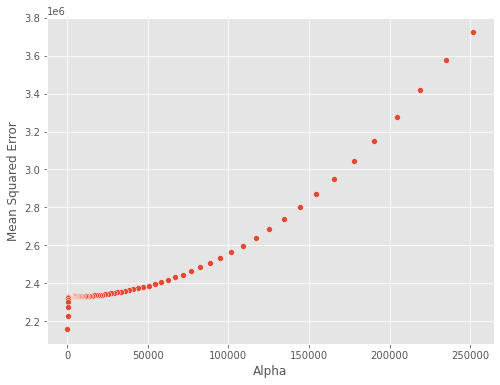

In [33]:
mse_path = model_lassocv.mse_path_.mean(axis = 1)
aplha_path = model_lassocv.alphas_

plt.figure(figsize = (8,6))
sns.scatterplot(aplha_path, mse_path)
plt.ylabel('Mean Squared Error')
plt.xlabel('Alpha')
plt.show()

In [34]:
# Fit model using above variables
model_lasso = smf.ols(formula='cnt ~ instant + mnth + weathersit + season', data = bike_train).fit()
model_lasso.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     112.0
Date:                Sat, 07 Aug 2021   Prob (F-statistic):          6.40e-157
Time:                        01:17:29   Log-Likelihood:                -4187.3
No. Observations:                 511   AIC:                             8411.
Df Residuals:                     493   BIC:                             8487.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1272.2848    151.117      8.419      0.000     975.371    1569.198
mnth[T.2]         410.5979    193.890      2.118      0.035      29.645     791.551
mnth[T.3]         941.0935    226.145      4.161      0.000     496.767    1385.420
mnth[T.4]        1196.8261    315.914      3.788      0.000     576.122    1817.530
mnth[T.5]        1754.4646    315.379      5.563      0.000    1134.811    2374.118
mnth[T.6]        1726.4611    306.897      5.626      0.000    1123.474    2329.449
mnth[T.7]        1310.9374    350.032      3.745      0.000     623.199    1998.676
mnth[T.8]        1261.8196    352.064      3.584      0.000     570.088    1953.552
mnth[T.9]        1162.9697    325.750      3.570      0.000     522.940    1803.000
mnth[T.10]         28.3565    324.971      0.087      0.931    -610.142     666.855
mnth[T.11]      -1278.7028    322.955     -3.959      0.000   -1913.240    -644.165
mnth[T.12]      -1628.8339    255.592     -6.373      0.000   -2131.017   -1126.650
weathersit[T.2]  -720.4097     86.513     -8.327      0.000    -890.390    -550.429
weathersit[T.3] -2788.8131    255.436    -10.918      0.000   -3290.690   -2286.936
season[T.2]       744.9959    245.754      3.031      0.003     262.141    1227.851
season[T.3]       997.4490    288.495      3.457      0.001     430.619    1564.279
season[T.4]      1677.3132    248.432      6.752      0.000    1189.198    2165.429
instant             5.7798      0.216     26.756      0.000       5.355       6.204
==============================================================================
Omnibus:                      119.827   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              426.986
Skew:                          -1.043   Prob(JB):                     1.91e-93
Kurtosis:                       6.963   Cond. No.                     9.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
train_pred = model_lasso.predict(X_train)
train_error = y_train['cnt'] - train_pred
train_RMSE = np.sqrt((train_error*train_error).mean())
train_RMSE

876.0422503481765

In [36]:
test_pred = model_lasso.predict(X_test)
test_error = y_test['cnt'] - test_pred
test_RMSE = np.sqrt((test_error*test_error).mean())
test_RMSE

851.3598342990753

In [37]:
# Regression Trees

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

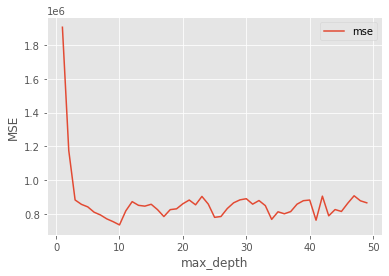

In [38]:
# Determine optimum depth for the tree

max_depth = []
mse_arr = []

for i in range(1,50):
 dtree = DecisionTreeRegressor(max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 mse = (mean_squared_error(y_test,pred))
 mse_arr.append(mse)
 ####
 max_depth.append(i)


d = pd.DataFrame({'mse_arr':pd.Series(mse_arr),
 'max_depth':pd.Series(max_depth)})

# visualizing changes in parameters
plt.plot('max_depth','mse_arr', data=d, label='mse')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend()

In [39]:
# Fit regression tree with depth = 12

clf = DecisionTreeRegressor(max_depth = 8, random_state = 0)
clf.fit(X_train, y_train)
text_representation = tree.export_text(clf, feature_names = list(X_train.columns.values))
#print(text_representation)

In [40]:
pred = clf.predict(X_test)
rmse = np.sqrt((mean_squared_error(y_test,pred)))
print(rmse)

901.5157520151779


In [41]:
# Random Forest

# Convert to numpy array
X_train_arr = np.array(X_train_d)
X_test_arr = np.array(X_test_d)
y_train_arr = np.array(y_train_d)
y_test_arr = np.array(y_test_d)

In [42]:
# Random Forest

# Convert to numpy array
X_train_arr = np.array(X_train)
X_test_arr = np.array(X_test)
y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)

In [43]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(bootstrap = True, criterion = 'mse', n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X_train_arr, y_train_arr);

<ipython-input-43-f35af9e94a17>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_arr, y_train_arr);


In [44]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test_arr)

# Calculate the absolute errors
errors = abs(predictions - y_test_arr)

# Print out the mean absolute error (mae)
print('RMSE:', np.sqrt(np.mean(errors**2)))

RMSE: 2671.72154933285


In [45]:
# Test kaggle code

# lets copy for editing without effecting original
bikes_df_model_data = bike.copy()

outcome = 'cnt'

#making feature list for each modeling - experiment by adding feature to the exclusion list
feature = [feat for feat in list(bikes_df_model_data) if feat not in [outcome, 'instant', 'dteday']]

#spliting data into train and test portion
X_trian, X_test, y_train, y_test = train_test_split(bikes_df_model_data[feature],
                                                   bikes_df_model_data[outcome],
                                                   test_size=0.3, random_state=42)

from sklearn import linear_model
lr_model = linear_model.LinearRegression()

#training model in training set
lr_model.fit(X_trian, y_train)

# making predection using the test set
y_pred = lr_model.predict(X_test)

#root mean squared error
print('RMSE: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 838.76


In [46]:
# One hot encoding of whole data
# Keep relevant columns
bike_d = bike.drop(columns=['dteday'])
bike_d = pd.get_dummies(bike_d)

bike_d.head()

,instant,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,yr_0,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3
0,1,0.344167,0.805833,0.160446,985,1,0,0,0,1,...,0,0,0,0,1,1,0,0,1,0
1,2,0.363478,0.696087,0.248539,801,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
2,3,0.196364,0.437273,0.248309,1349,1,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
3,4,0.200000,0.590435,0.160296,1562,1,0,0,0,1,...,1,0,0,0,0,0,1,1,0,0
4,5,0.226957,0.436957,0.186900,1600,1,0,0,0,1,...,0,1,0,0,0,0,1,1,0,0


In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(array(bike_d['cnt']).reshape(len(bike_d['cnt']), 1))
series = pd.DataFrame(scaled)
series.columns = ['cntscl']

bike_scl = pd.merge(bike_d, series, left_index=True, right_index=True)
bike_scl.head()

,instant,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,yr_0,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,cntscl
0,1,0.344167,0.805833,0.160446,985,1,0,0,0,1,...,0,0,0,1,1,0,0,1,0,0.110792
1,2,0.363478,0.696087,0.248539,801,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0.089623
2,3,0.196364,0.437273,0.248309,1349,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0.152669
3,4,0.200000,0.590435,0.160296,1562,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0.177174
4,5,0.226957,0.436957,0.186900,1600,1,0,0,0,1,...,1,0,0,0,0,1,1,0,0,0.181546


In [48]:
#Split 

number_of_test_data = 70
number_of_holdout_data = 70
number_of_training_data = len(bike_d) - number_of_holdout_data - number_of_test_data
print ("total, train, test, holdout:", len(bike_d), number_of_training_data, number_of_test_data, number_of_holdout_data)

total, train, test, holdout: 731 591 70 70


In [49]:
datatrain = bike_scl[:number_of_training_data]
datatest = bike_scl[-(number_of_test_data+number_of_holdout_data):-number_of_holdout_data]
datahold = bike_scl[-number_of_holdout_data:]

In [50]:
datatrain.columns
#type(bike_d['holiday'])

Index(['instant', 'temp', 'hum', 'windspeed', 'cnt', 'season_1', 'season_2',
       'season_3', 'season_4', 'yr_0', 'yr_1', 'mnth_1', 'mnth_2', 'mnth_3',
       'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10',
       'mnth_11', 'mnth_12', 'holiday_0', 'holiday_1', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'workingday_0', 'workingday_1', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'cntscl'],
      dtype='object')

In [51]:
in_seq1 = array(datatrain['holiday_0'])
in_seq1_1 = array(datatrain['holiday_1'])
in_seq2 = array(datatrain['workingday_0'])
in_seq2_1 = array(datatrain['workingday_1'])
in_seq3 = array(datatrain['temp'])
in_seq5 = array(datatrain['hum'])
in_seq6 = array(datatrain['windspeed'])
in_seq7 = array(datatrain['weekday_0'])
in_seq8 = array(datatrain['weekday_1'])
in_seq9 = array(datatrain['weekday_2'])
in_seq10 = array(datatrain['weekday_3'])
in_seq11 = array(datatrain['weekday_4'])
in_seq12 = array(datatrain['weekday_5'])
in_seq13 = array(datatrain['weekday_6'])
in_seq14 = array(datatrain['weathersit_1'])
in_seq15 = array(datatrain['weathersit_2'])
in_seq16 = array(datatrain['weathersit_3'])
out_seq_train = array(datatrain['cntscl'])

In [52]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq1_1 = in_seq1_1.reshape((len(in_seq1_1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq2_1 = in_seq2_1.reshape((len(in_seq2_1), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_train = out_seq_train.reshape((len(out_seq_train), 1))

In [53]:
datatrain_feed = hstack((in_seq1, in_seq1_1, in_seq2,in_seq2_1, in_seq3,  in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_train))

In [54]:
in_seq1 = array(datatest['holiday_0'])
in_seq1_1 = array(datatest['holiday_1'])
in_seq2 = array(datatest['workingday_0'])
in_seq2_1 = array(datatest['workingday_1'])
in_seq3 = array(datatest['temp'])
in_seq5 = array(datatest['hum'])
in_seq6 = array(datatest['windspeed'])
in_seq7 = array(datatest['weekday_0'])
in_seq8 = array(datatest['weekday_1'])
in_seq9 = array(datatest['weekday_2'])
in_seq10 = array(datatest['weekday_3'])
in_seq11 = array(datatest['weekday_4'])
in_seq12 = array(datatest['weekday_5'])
in_seq13 = array(datatest['weekday_6'])
in_seq14 = array(datatest['weathersit_1'])
in_seq15 = array(datatest['weathersit_2'])
in_seq16 = array(datatest['weathersit_3'])
out_seq_test = array(datatest['cntscl'])

In [55]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq1_1 = in_seq1_1.reshape((len(in_seq1_1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq2_1 = in_seq2_1.reshape((len(in_seq2_1), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_test = out_seq_test.reshape((len(out_seq_test), 1))

In [56]:
datatest_feed = hstack((in_seq1,in_seq1_1, in_seq2, in_seq2_1, in_seq3, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_test))

In [57]:
in_seq1 = array(datahold['holiday_0'])
in_seq1_1 = array(datahold['holiday_1'])
in_seq2 = array(datahold['workingday_0'])
in_seq2_1 = array(datahold['workingday_1'])
in_seq3 = array(datahold['temp'])
in_seq5 = array(datahold['hum'])
in_seq6 = array(datahold['windspeed'])
in_seq7 = array(datahold['weekday_0'])
in_seq8 = array(datahold['weekday_1'])
in_seq9 = array(datahold['weekday_2'])
in_seq10 = array(datahold['weekday_3'])
in_seq11 = array(datahold['weekday_4'])
in_seq12 = array(datahold['weekday_5'])
in_seq13 = array(datahold['weekday_6'])
in_seq14 = array(datahold['weathersit_1'])
in_seq15 = array(datahold['weathersit_2'])
in_seq16 = array(datahold['weathersit_3'])
out_seq_hold = array(datahold['cntscl'])

In [58]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq1_1 = in_seq1_1.reshape((len(in_seq1_1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq2_1 = in_seq2_1.reshape((len(in_seq2_1), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
in_seq16 = in_seq16.reshape((len(in_seq16), 1))
out_seq_hold = out_seq_hold.reshape((len(out_seq_hold), 1))

In [59]:
datahold_feed = hstack((in_seq1,in_seq1_1, in_seq2,in_seq2_1, in_seq3, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, in_seq16, out_seq_hold))

In [60]:
n_features = datatrain_feed.shape[1]
n_input = 10
generator_train = TimeseriesGenerator(datatrain_feed, out_seq_train, length=n_input, batch_size=len(datatrain_feed))

In [61]:
generator_test = TimeseriesGenerator(datatest_feed, out_seq_test, length=n_input, batch_size=1)
generator_hold = TimeseriesGenerator(datahold_feed, out_seq_hold, length=n_input, batch_size=1)

In [62]:
type(n_features)

int

In [63]:
pip install numpy==1.19.5

Note: you may need to restart the kernel to use updated packages.


In [67]:
# Modeling

model = Sequential()


model.add(SimpleRNN(4, activation='relu', input_shape=(n_input,n_features), return_sequences = False))
model.add(Dense(1, activation='relu'))

adam = Adam(lr=0.0001)
model.compile(optimizer='adam', loss='mse')




model.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 4)                 92        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [71]:
score = model.fit(generator_train, epochs=3000, verbose=0, validation_data=generator_test)

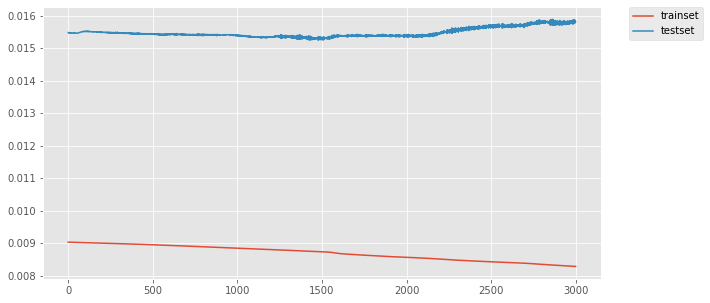

In [72]:
losses = score.history['loss']
val_losses = score.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(losses, label="trainset")
plt.plot(val_losses, label="testset")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [76]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_test)):
    x, y = generator_test[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)




1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s


In [77]:
    
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']   

df_result

,Actual,Prediction,Diff
0,7582.0,6718.314941,-11.391256
1,6053.0,6725.119141,11.103901
2,5255.0,6477.092285,23.255800
3,6917.0,6142.129395,-11.202409
4,7040.0,6925.572266,-1.625394
5,7697.0,6421.577637,-16.570383
6,7713.0,6807.048340,-11.745775
7,7350.0,7081.876953,-3.647933
8,6140.0,6749.207031,9.921939
9,5810.0,6259.786133,7.741586


In [82]:
mean = df_result['Actual'].mean()
mae = (df_result['Actual'] - df_result['Prediction']).abs().mean()
rmse = (np.sqrt((df_result['Actual'] - df_result['Prediction'])*(df_result['Actual'] - df_result['Prediction']))).mean()

print("mean: ", mean)
print("mae:", mae)
print("mae/mean ratio: ", 100*mae/mean,"%")
print("correctness: ", 100 - 100*mae/mean,"%")

print("rmse:", rmse)

mean:  7067.733333333334
mae: 834.511376953125
mae/mean ratio:  11.807341018616883 %
correctness:  88.19265898138312 %
rmse: 834.511376953125


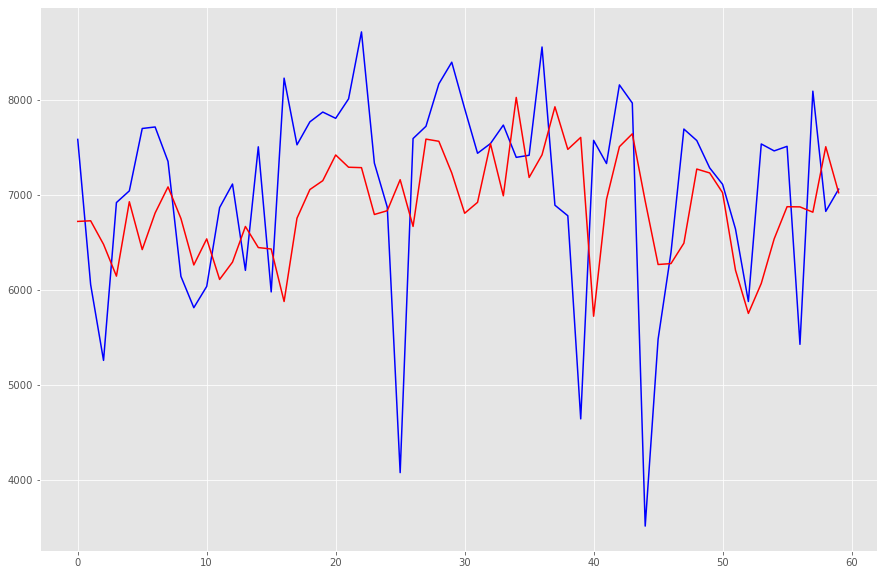

In [83]:
plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()

In [84]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)

1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s


In [85]:


df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']

df_result

,Actual,Prediction,Diff
0,5847.0,6379.038574,9.099343
1,5138.0,5900.713379,14.844558
2,5107.0,5120.738770,0.269018
3,5259.0,5536.686523,5.280215
4,5686.0,5340.162598,-6.082262
5,5035.0,5107.199707,1.433956
6,5315.0,4817.279297,-9.364453
7,5992.0,5427.998047,-9.412583
8,6536.0,5879.587402,-10.043032
9,6852.0,5511.656738,-19.561344


In [86]:
mean = df_result['Actual'].mean()
mae = (df_result['Actual'] - df_result['Prediction']).abs().mean()
rmse = (np.sqrt((df_result['Actual'] - df_result['Prediction'])*(df_result['Actual'] - df_result['Prediction']))).mean()

print("mean: ", mean)
print("mae:", mae)
print("mae/mean ratio: ", 100*mae/mean,"%")
print("correctness: ", 100 - 100*mae/mean,"%")

print("rmse:", rmse)

mean:  4506.516666666666
mae: 897.0698689778645
mae/mean ratio:  19.906059054728846 %
correctness:  80.09394094527116 %
rmse: 897.0698689778645


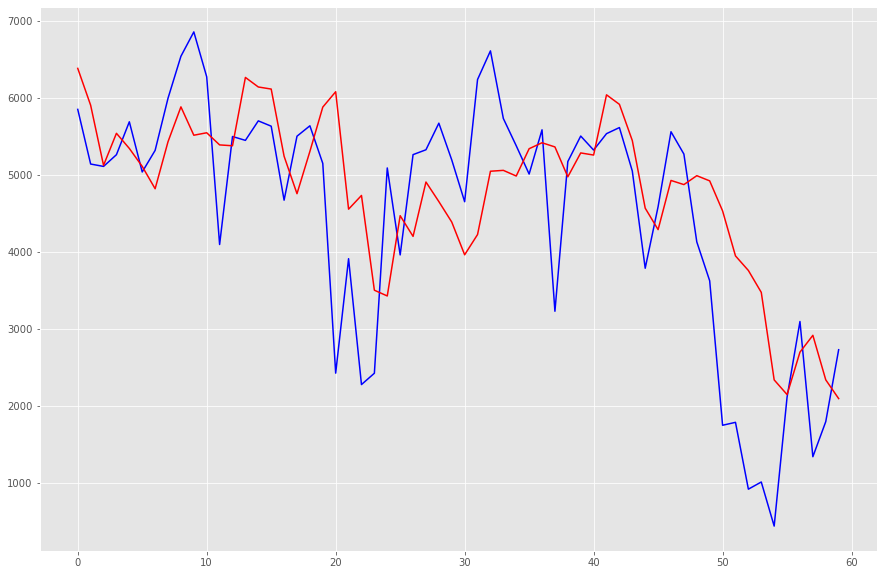

In [87]:
plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()

In [ ]:
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.gam.tests.test_penalized import df_autos


bs = BSplines(bike_train, df=[12, 10], degree=[3, 3])

gam_bs = GLMGam.from_formula('cnt ~ yr + mnth + instant + season + holiday + weekday + workingday + weathersit + temp + hum + windspeed', data=bike_train, smoother=bs)

res_bs = gam_bs.fit()
print(res_bs.summary())

In [ ]:
import numpy as np
import pandas as pd
from pygam import GAM, LinearGAM, s, f, te

# Your training and test datasets should be split as X_train, X_test, y_train, y_test
n_features = 4

# Number of features used in the model
lams = np.logspace(-5,5,20) * n_features
splines = 12
# Number of splines we will use
# Linear GAM for Regression

gam = LinearGAM(
                s(0,n_splines=splines)).gridsearch(
                X_train, 
                y_train,
                lam=lams)
gam.summary()
#print(mean_squared_error(X_test,y_test))